In [2]:
%pip install torch scikit-image matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import numpy as np
import torch  # https://pytorch.org
from typing import *
import matplotlib.pyplot as plt
import skimage

In [4]:
import random
def gen_img():
    return torch.rand(400,400,3)

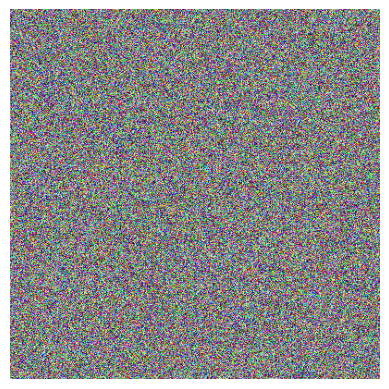

In [5]:
%matplotlib inline

plt.imshow(gen_img())
plt.axis('off')
plt.show()

In [6]:
from functools import reduce
def tot_chans(img):
    return reduce(lambda x,y: x*y, img.shape)

In [7]:
def noise_like(st: torch.Tensor):
    """Generates normally distributed noise shaped like `st`."""
    return torch.randn(st.shape).to("cuda")

In [8]:
def disp_img(im):
    if im.shape[2] != 3:
        im = torch.moveaxis(im,0,2)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

(3, 256, 256)


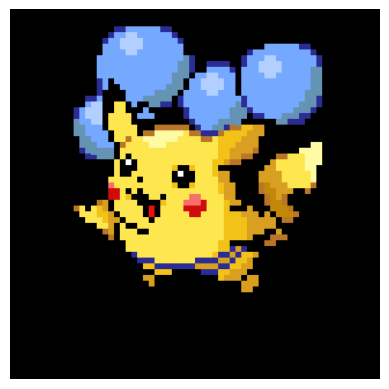

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.3685746..4.9765763].


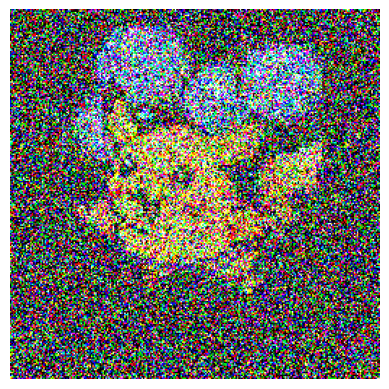

In [9]:
pika_img = skimage.io.imread("./pikachu.png")
pika_img = np.moveaxis(pika_img,2,0)
pika_img = np.delete(pika_img, 3, axis=0)
print(pika_img.shape)
pika_img = torch.tensor(pika_img).to('cuda')
pika_img = pika_img.float() / 255
noise = noise_like(pika_img).to('cuda')
disp_img(pika_img.cpu())
disp_img((pika_img+noise).cpu())

In [10]:
from torch_unet import UNet

In [11]:
x = torch.nn.ConvTranspose2d(in_channels=1024,out_channels=512, stride=2, kernel_size=2)
x(torch.rand(1024,4,4)).shape

torch.Size([512, 8, 8])

In [12]:
u = UNet(in_channels=3, out_channels=3)
u = u.to('cuda')

In [13]:
pika_img.to('cuda')
u(torch.stack([pika_img.to('cuda') for _ in range(5)],dim=0)).shape

/home/j/diff-torch/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([5, 3, 256, 256])

In [14]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Download thumbnails from URLs of the form: https://raw.githubusercontent.com/HybridShivam/Pokemon/master/assets/thumbnails/xxx.png
# where xxx ranges from 001 to 905

# Load them into memory and convert them to (156,156,3) tensors using scikit-image

from skimage import io
import requests
from io import BytesIO

from functools import cache

@cache
def img_to_tensor(url):
  response = requests.get(url)
  img_bytes = BytesIO(response.content)
  img_array = io.imread(img_bytes)
  img_tensor = np.swapaxes(img_array, 0, 2)
  img_tensor = np.delete(img_tensor, 3, axis=0)
  return img_tensor

def download_images():
  url_format = "https://raw.githubusercontent.com/HybridShivam/Pokemon/master/assets/thumbnails/{:03d}.png"

  # Initialize empty list for storing images
  images = []

  # Loop through all IDs from 001 to 905
  for i in range(1, 906):
      # Construct the URL for the current ID
      url = url_format.format(i)

      # Download the image from the URL
      image = img_to_tensor(url)

      # convert from 0-255 int RGB to 0-1 float RGB
      image = image.astype(float) / 255

      # Append the image to the list
      images.append(image)
  return images

In [16]:
import os
import pickle
if os.path.exists("./images.pkl"):
    with open("./images.pkl", "rb") as p:
        images = pickle.load(p)
else:
    images = download_images()
    with open("./images.pkl", "wb") as p:
        pickle.dump(images,p)


In [17]:
# rotate each image in images by -pi/2
for i in range(len(images)):
    images[i] = np.rot90(images[i], k=-1, axes=(1, 2))

In [18]:
images = [torch.tensor(a.copy()) for a in images]

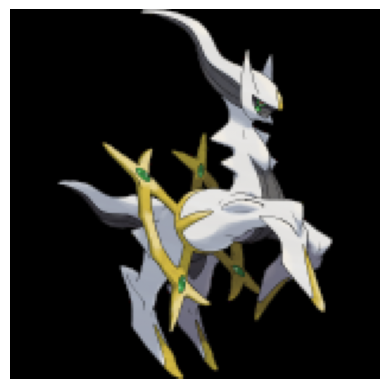

In [19]:
disp_img(images[492])

In [20]:
images = filter(lambda x: x.shape[1] == 156 and x.shape[2] == 156, images)
images = list(images)

In [21]:
def loss(model, noised, og):
    pred_noise = model(noised)
    real_noise = noised-og
    return ((pred_noise-real_noise)**2).mean()

In [22]:
# tfd distribution that returns a random entry from images
class ImageDist(torch.distributions.Distribution):
    def __init__(self, images):
        self.images = images

    def sample(self, size=1):
      return torch.stack([self.images[random.randrange(0,len(self.images))] for _ in range(size)], axis=0)

In [23]:
d = ImageDist(images)
d.sample(10).shape

torch.Size([10, 3, 156, 156])

In [24]:
import math

In [25]:
default_noising_schedule = torch.tensor(np.linspace(.0001,.02,1000))

In [26]:
def alpha_bar(t,noising_schedule):
  return reduce(lambda x,y: x*y,[1 - beta for beta in noising_schedule[:t+1]])

In [27]:
def add_noise(img, t, noising_schedule):
  return math.sqrt(alpha_bar(t,noising_schedule)) * img + math.sqrt(1 - alpha_bar(t,noising_schedule)) * noise_like(img)

In [28]:
import torch.optim as optim
def train(model, steps, batch_size, print_every: int, training_dist, noising_schedule):
  # Define the loss function and optimizer
  opt = optim.Adam(model.parameters(), lr=0.001)

  max_temp = len(noising_schedule)
  temp_dist = torch.tensor(range(0,max_temp))

  def alpha_bar(t):
    return alpha_bar(t, noising_schedule)
  def noised(img, t):
    return add_noise(img, t, noising_schedule)

  def make_step(epoch):
      t = random.choice(temp_dist)
      batch = training_dist.sample(size=batch_size).to('cuda')
      L = loss(model, noised(batch,t), batch)
      opt.zero_grad()
      L.backward()

      opt.step()
      print(f"{epoch+1}/{steps}: {L.item():.5f}")

  for epoch in range(steps):
    make_step(epoch)
  return model

In [29]:
images = [i.to('cuda', dtype=torch.float32) for i in images]

In [30]:
def pad_to_shape(x, target_shape):
    p = [0] * (2 * len(target_shape))
    for i, s in enumerate(target_shape):
        p[2 * (len(target_shape) - 1 - i) + 1] = s - x.size(i)
    return torch.nn.functional.pad(x, p)

In [31]:
images = torch.stack([pad_to_shape(i, (3,156,156)) for i in images], dim=0)

In [32]:
if os.path.exists("./denoising_model.pt"):
    u = torch.serialization.load("denoising_model.pt", map_location="cuda")
else:
    train(u, 1000, 50, 1, ImageDist(images), default_noising_schedule)

In [33]:
# u = train(u,80000,50,1,ImageDist(images), default_noising_schedule)

In [34]:
torch.serialization.save(u, "denoising_model.pt")

In [160]:
def sample(model, schedule, limit=None, seed=None):
  with torch.no_grad():  
    if limit is None:
      limit = len(schedule)
    if seed is None:
      seed = noise_like(images[0])
    def stacked(a):
      return torch.stack([a], dim=0)
    def alpha(t):
      return 1 - schedule[t-1]
    x = stacked(seed)
    for t in reversed(range(1,limit+1)):
      real_t = len(schedule)-limit+t-1
      z = 0 if t == 1 else stacked(noise_like(images[1]))
      sigma = math.sqrt(schedule[real_t-1])
      noise_scale = (1 - alpha(real_t))/(torch.sqrt(alpha_bar(real_t,schedule)))
      new_x = (1/torch.sqrt(alpha(real_t))) * (x - noise_scale*model(x)) + sigma * z
      new_x = new_x * 1/new_x.max()
      x.to('cpu')
      del x
      x = new_x
    return x

In [36]:
def denoise(model, im, gas):
    with torch.no_grad():    
        im = torch.stack([im], dim=0)
        for _ in range(gas):
            im = im - model(im)
        return im

In [37]:
def disp_denoised(img):
    disp_img(img.reshape(*images[0].shape).detach().cpu())

In [68]:
torch.seed()

7901638658040297930

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15270168..1.8116409].


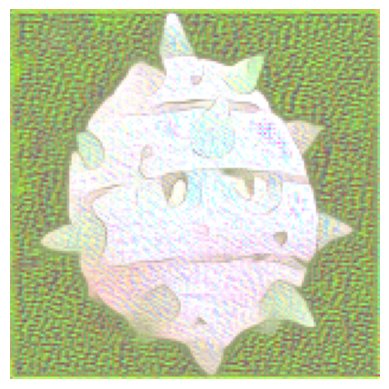

In [141]:
disp_denoised(denoise(u, noise_like(images[0]), 30))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1630268..1.0].


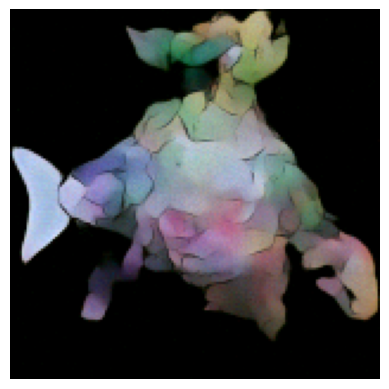

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65766764..1.0].


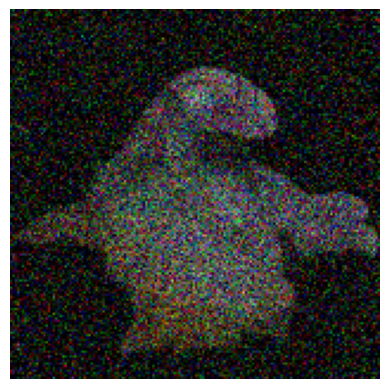

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.120456174..1.0].


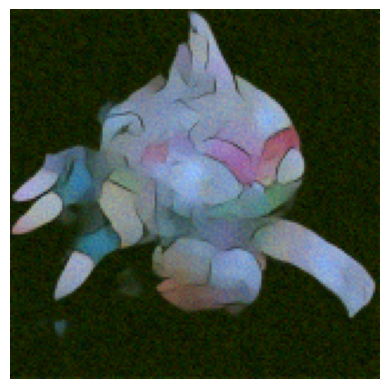

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2554465..1.0].


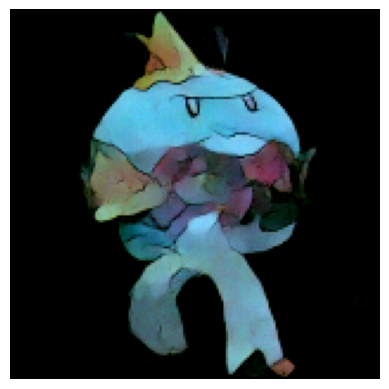

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2014329..1.0].


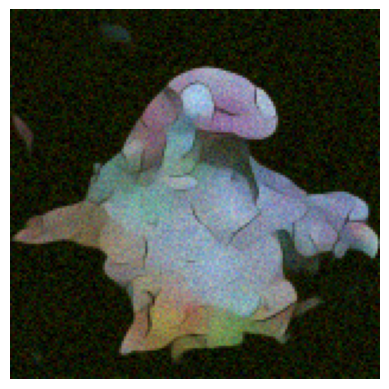

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30592862..1.0].


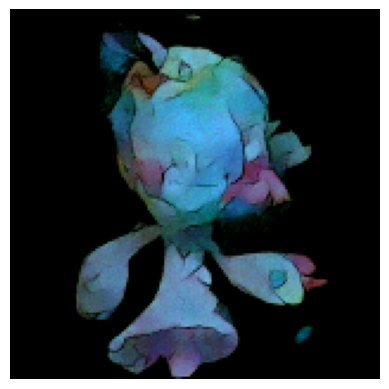

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17108616..1.0].


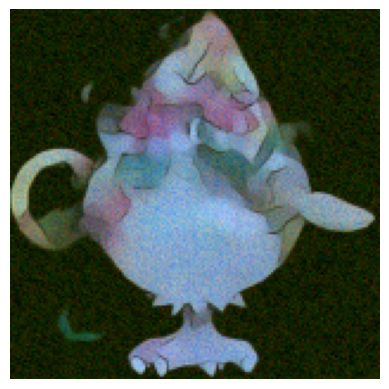

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15476179..1.0].


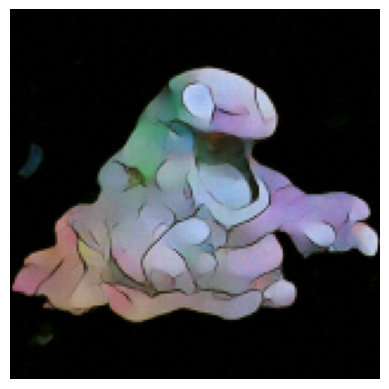

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016994732..1.0].


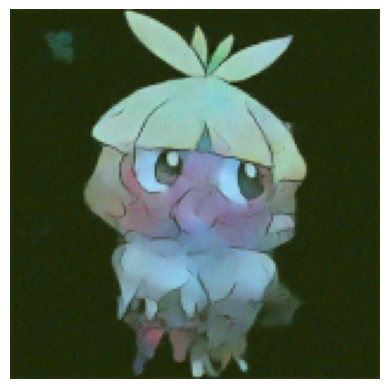

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0036962864..1.0].


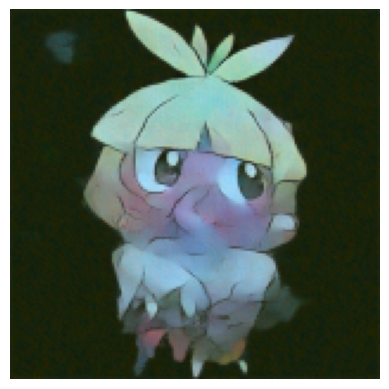

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22791332..1.0].


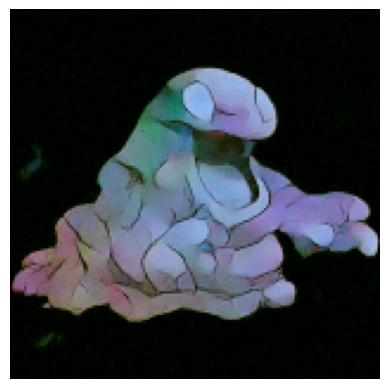

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09909551..1.0].


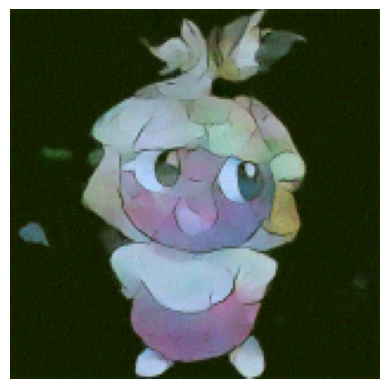

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20842974..1.0].


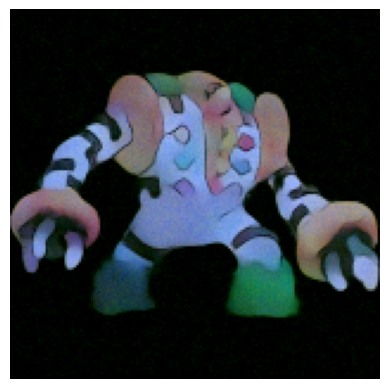

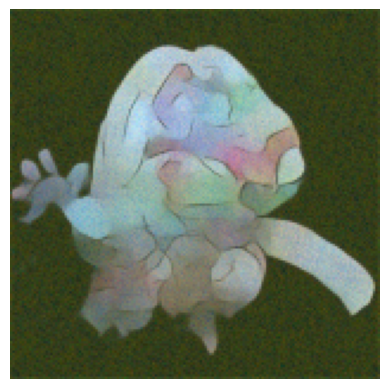

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0070959046..1.0].


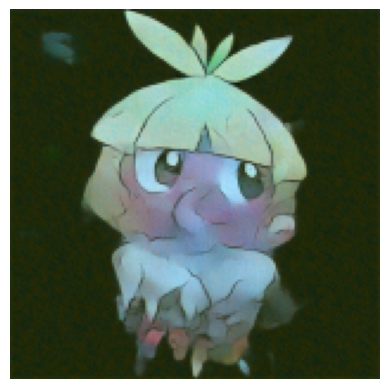

In [173]:
for _ in range(15):
    disp_denoised(sample(u, default_noising_schedule, limit=random.randrange(150,200), seed=None))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1814814..4.4587054].


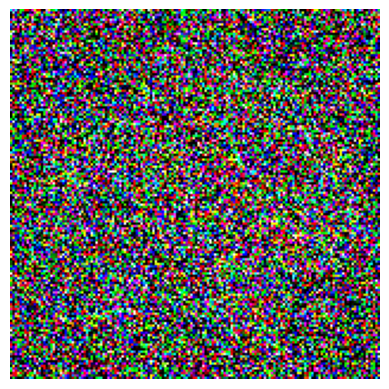

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.447323..9.489339].


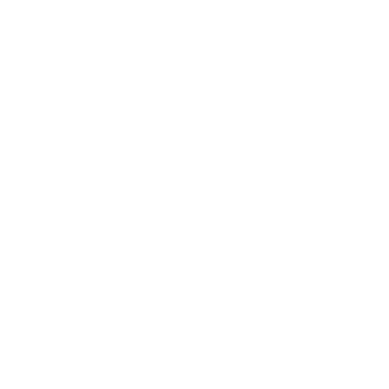

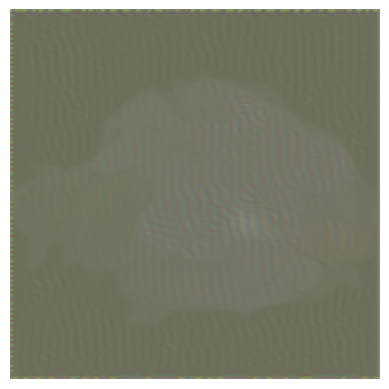

In [346]:
noised = add_noise(images[490], 600, default_noising_schedule)
disp_img(noised.cpu())
d = denoise(u, noised, 200).detach().cpu()
normed = (1/math.sqrt(200)) * d
disp_denoised(d)
disp_denoised(normed)

In [155]:
noise = noise_like(images[1])
denoised = denoise(u, noise, 10)
disp_denoised(denoised)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [ ]:
# denoised = denoise(u, noise, 15)
# disp_denoised(denoised)

In [ ]:
disp_img(add_noise(images[0], 100, default_noising_schedule).cpu())

In [ ]:
disp_denoised(denoise(u, add_noise(images[0],100,default_noising_schedule),4))

In [ ]:
model()

In [ ]:
key = jax.random.PRNGKey(0)
model = train(model,optim,1000,0,ImageDist(images),jnp.linspace(0.0001,.02,1000), key)

In [ ]:
disp_img(images[0])

In [ ]:
bulbasaur = images[0]
bulbasaur.shape

In [ ]:
disp_img(noise_like(bulbasaur, jax.random.PRNGKey(100)))

In [ ]:
noised_bulbasaur = add_noise(images[0], 300, default_noising_schedule, jax.random.PRNGKey(0))
disp_img(noised_bulbasaur)
# disp_img(denoise(model,noised_bulbasaur,500))

In [ ]:
images[0].shape

In [ ]:
disp_img(denoise(model, noised_bulbasaur, 500, key))

In [ ]:
eqx.tree_serialise_leaves("model.eqx", model)

In [ ]:
noised = noise_like(pika_img) + pika_img
disp_img(noised)
disp_img(noised - model(1,noised,key=key))

In [ ]:
loss(model,noised,pika_img,key)